In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import numpy as np
import cv2
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data.dataset import random_split







class Experiment:

    def __init__(self):

        # Set the width and height of the grid
        self.width = 8
        self.height = 8
        
        self.Target_position_grid = np.eye(self.width,dtype=float)
        for i in range(self.width-1):
            self.Target_position_grid[i,i-1] = 1
            self.Target_position_grid[i,i+1] = 1
            
        self.Target_position_grid[self.width-1,self.width-1] = 1
        self.Target_position_grid[self.width-1,self.width - 2] = 1


    def data_generator(self):
        x = np.random.randint(0,7)
        y = np.random.randint(0,7)
 
        sun = np.random.random_sample()
        rain = np.random.random_sample()
        #data = torch.tensor([x/8,y/8,sun,rain])
        target = self.Target_position_grid[x,y]
        data = [x,y]      
        return data
        
    def Create_Dataset(self,SIZE,BATCH_SIZE):
        
        data = [self.data_generator() for i in range(SIZE)]
        target =[self.Target_position_grid[a[0],a[1]] for a in data]
        data, target = torch.tensor(data,dtype=torch.float32), torch.tensor(target,dtype=torch.float32)

        dataset = TensorDataset(data, target)
        train_dataset, val_dataset = random_split(dataset, [int(np.floor(0.8*SIZE)), int(np.floor(0.2*SIZE))])
        train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE)
        val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE)

        return train_loader,val_loader

#Proposition of 2 Networkds wooth diff number of neurons and layers

class Net_Task1(torch.nn.Module):
    def __init__(self,input_dimension, output_dimension):
        super(Net_Task1, self).__init__()
        self.fc1 = nn.Linear(in_features = input_dimension, out_features = 1)
        self.fc2 = nn.Linear(in_features = 1, out_features = 2)
        self.fc3 = nn.Linear(in_features = 2,  out_features = output_dimension)


    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.sigmoid(x)


class Net_Task2(torch.nn.Module):
    def __init__(self,input_dimension, output_dimension):
        super(Net_Task2, self).__init__()
        self.fc1 = nn.Linear(in_features = input_dimension, out_features = 5)
        self.fc2 = nn.Linear(in_features = 5, out_features = 5)
        self.fc3 = nn.Linear(in_features = 5, out_features = 5)
        self.fc4 = nn.Linear(in_features = 5, out_features = 5)
        self.fc5 = nn.Linear(in_features = 5,  out_features = output_dimension)

        #self.mask2 = torch.tensor([[1,0],[1,0],[0,1],[0,1]])
        #self.mask3 = torch.tensor([[1,1,0,0],[0,0,1,1]]) 


    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return torch.sigmoid(x)



class Training(Experiment):

  # The class initialisation function.
    def __init__(self,model,opti,loss):
        self.model = model
        self.optimizer = opti
        self.criterion = loss
    
    def train_network(self,data,target):
        Loss = []  
        #Compute the prediction
        output = self.model.forward(data)
        # Calculate the loss for this transition.
        loss =  self.criterion(output,target.unsqueeze(1))
        # Set all the gradients stored in the optimiser to zero.
        self.optimizer.zero_grad()
        # Compute the gradients based on this loss, i.e. the gradients of the loss with respect to the Q-network parameters.
        loss.backward()    
        # Take one gradient step to update the Q-network. 
        self.optimizer.step()
        # Return the loss as a scalar
        return loss


In [25]:
torch.manual_seed(42)

Size_total_dataset = 1000
Batch_size = 32
n_epochs = 100
learning_rate = 0.001


experiment = Experiment()
train_loader,val_loader = experiment.Create_Dataset(SIZE = Size_total_dataset,BATCH_SIZE = Batch_size)

Size val_loader 7
Size train_loader 25


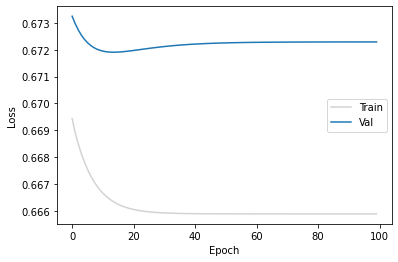

In [26]:
### MAIN ###

model = Net_Task1(input_dimension = 2, output_dimension = 1)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.BCELoss()
experiment = Experiment()
train = Training(model,optimizer,criterion)


print("Size val_loader",len(val_loader))
print("Size train_loader",len(train_loader))

losses = []
val_losses = []

for epoch in range(n_epochs):
    loss = 0
    val_loss = 0 
    for x_batch, y_batch in train_loader:

        loss += train.train_network(x_batch, y_batch).detach().numpy()
    losses.append(loss/len(train_loader))
        
    with torch.no_grad():
        for x_val, y_val in val_loader:

            model.eval()

            yhat = model(x_val)
            val_loss += criterion( yhat,y_val.unsqueeze(1))
        val_losses.append(val_loss.item()/len(val_loader))





l_epoch = [i for i in range(len(losses))]
l_epoch_val = [i for i in range(len(val_losses))]

plt.figure()
plt.plot(l_epoch,losses, '-', color='lightgrey', label='Train')
plt.plot(l_epoch_val,val_losses, '-', label='Val')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()


2nd Network with 5 layers

Size val_loader 7
Size train_loader 25


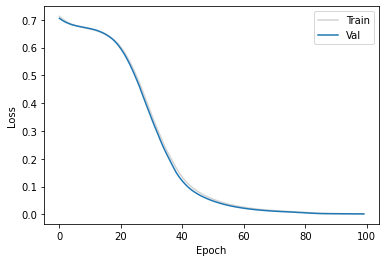

In [27]:
### MAIN ###



model = Net_Task2(input_dimension = 2, output_dimension = 1)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.BCELoss()
experiment = Experiment()
train = Training(model,optimizer,criterion)


print("Size val_loader",len(val_loader))
print("Size train_loader",len(train_loader))

losses = []
val_losses = []

for epoch in range(n_epochs):
    loss = 0
    val_loss = 0 
    for x_batch, y_batch in train_loader:

        loss += train.train_network(x_batch, y_batch).detach().numpy()
    losses.append(loss/len(train_loader))
        
    with torch.no_grad():
        for x_val, y_val in val_loader:

            model.eval()

            yhat = model(x_val)
            val_loss += criterion( yhat,y_val.unsqueeze(1))
        val_losses.append(val_loss.item()/len(val_loader))


l_epoch = [i for i in range(len(losses))]
l_epoch_val = [i for i in range(len(val_losses))]

plt.figure()
plt.plot(l_epoch,losses, '-', color='lightgrey', label='Train')
plt.plot(l_epoch_val,val_losses, '-', label='Val')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()




